# Ujian AKhir Semester Machine Learning

In [2]:
# ============== CORE LIBRARIES ==============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# ============== MACHINE LEARNING ==============
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
import xgboost as xgb
from scipy import stats

# ============== DEEP LEARNING ==============
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# ============== UTILITIES ==============
import time
import joblib
from scipy.stats import zscore

# ============== CONFIGURATION ==============
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print(" All libraries imported successfully!")
print(f" TensorFlow version: {tf.__version__}")
print(f" NumPy version: {np.__version__}")
print(f" Pandas version: {pd.__version__}")

 All libraries imported successfully!
 TensorFlow version: 2.18.0
 NumPy version: 1.26.4
 Pandas version: 2.2.3


SECTION 1: DATA LOADING & INITIAL EXPLORATION

In [3]:
# ============== PATH CONFIGURATION ==============
BASE_DIR = os.getcwd()  # sudah di folder regresi
DATA_PATH = os.path.join(BASE_DIR, 'midterm-regresi-dataset.csv')
SAVE_DIR = BASE_DIR

# Ensure save directory exists
os.makedirs(SAVE_DIR, exist_ok=True)

print("="*80)
print("LOADING DATASET...")
print("="*80)

# Load data WITHOUT header (karena file asli tidak punya header)
df_raw = pd.read_csv(DATA_PATH, header=None)

# ============== PROPER COLUMN NAMING ==============
# Column 0 = Year (Target), Column 1-90 = Audio Features
column_names = ['year'] + [f'feature_{i}' for i in range(1, 91)]
df_raw.columns = column_names

print(f"\n✅ Data loaded successfully!")
print(f"📊 Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"💾 File Size: {os.path.getsize(DATA_PATH) / (1024**2):.2f} MB")

# ============== INITIAL DATA INSPECTION ==============
print("\n" + "="*80)
print("INITIAL DATA INSPECTION")
print("="*80)

print("\n1️⃣ First 5 Rows:")
print(df_raw.head())

print("\n2️⃣ Last 5 Rows:")
print(df_raw.tail())

print("\n3️⃣ Data Types:")
print(df_raw.dtypes.value_counts())

print("\n4️⃣ Memory Usage:")
print(f"Total Memory: {df_raw.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

print("\n5️⃣ Basic Statistics:")
print(df_raw.describe().T)

LOADING DATASET...

✅ Data loaded successfully!
📊 Dataset Shape: 515,345 rows × 91 columns
💾 File Size: 422.88 MB

INITIAL DATA INSPECTION

1️⃣ First 5 Rows:
   year  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  2001    49.9436    21.4711    73.0775     8.7486   -17.4063   -13.0991   
1  2001    48.7321    18.4293    70.3268    12.9464   -10.3244   -24.8378   
2  2001    50.9571    31.8560    55.8185    13.4169    -6.5790   -18.5494   
3  2001    48.2475    -1.8984    36.2977     2.5878     0.9717   -26.2168   
4  2001    50.9702    42.2100    67.0996     8.4679   -15.8528   -16.8141   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0   -25.0120   -12.2326     7.8309     -2.4678      3.3214     -2.3152   
1     8.7663    -0.9202    18.7655      4.5921      2.2192      0.3401   
2    -3.2787    -2.3504    16.0702      1.3952      2.7355      0.8280   
3     5.0510   -10.3412     3.5501     -6.3630      6.6302     -3.3514   
4   -12.4

SECTION 2: COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)


EXPLORATORY DATA ANALYSIS (EDA)

 TARGET VARIABLE ANALYSIS (YEAR)
--------------------------------------------------------------------------------
count    515345.0000
mean       1998.3971
std          10.9310
min        1922.0000
25%        1994.0000
50%        2002.0000
75%        2006.0000
max        2011.0000
Name: year, dtype: float64

 Year Range: 1922 - 2011
 Year Span: 89 years
 Unique Years: 89


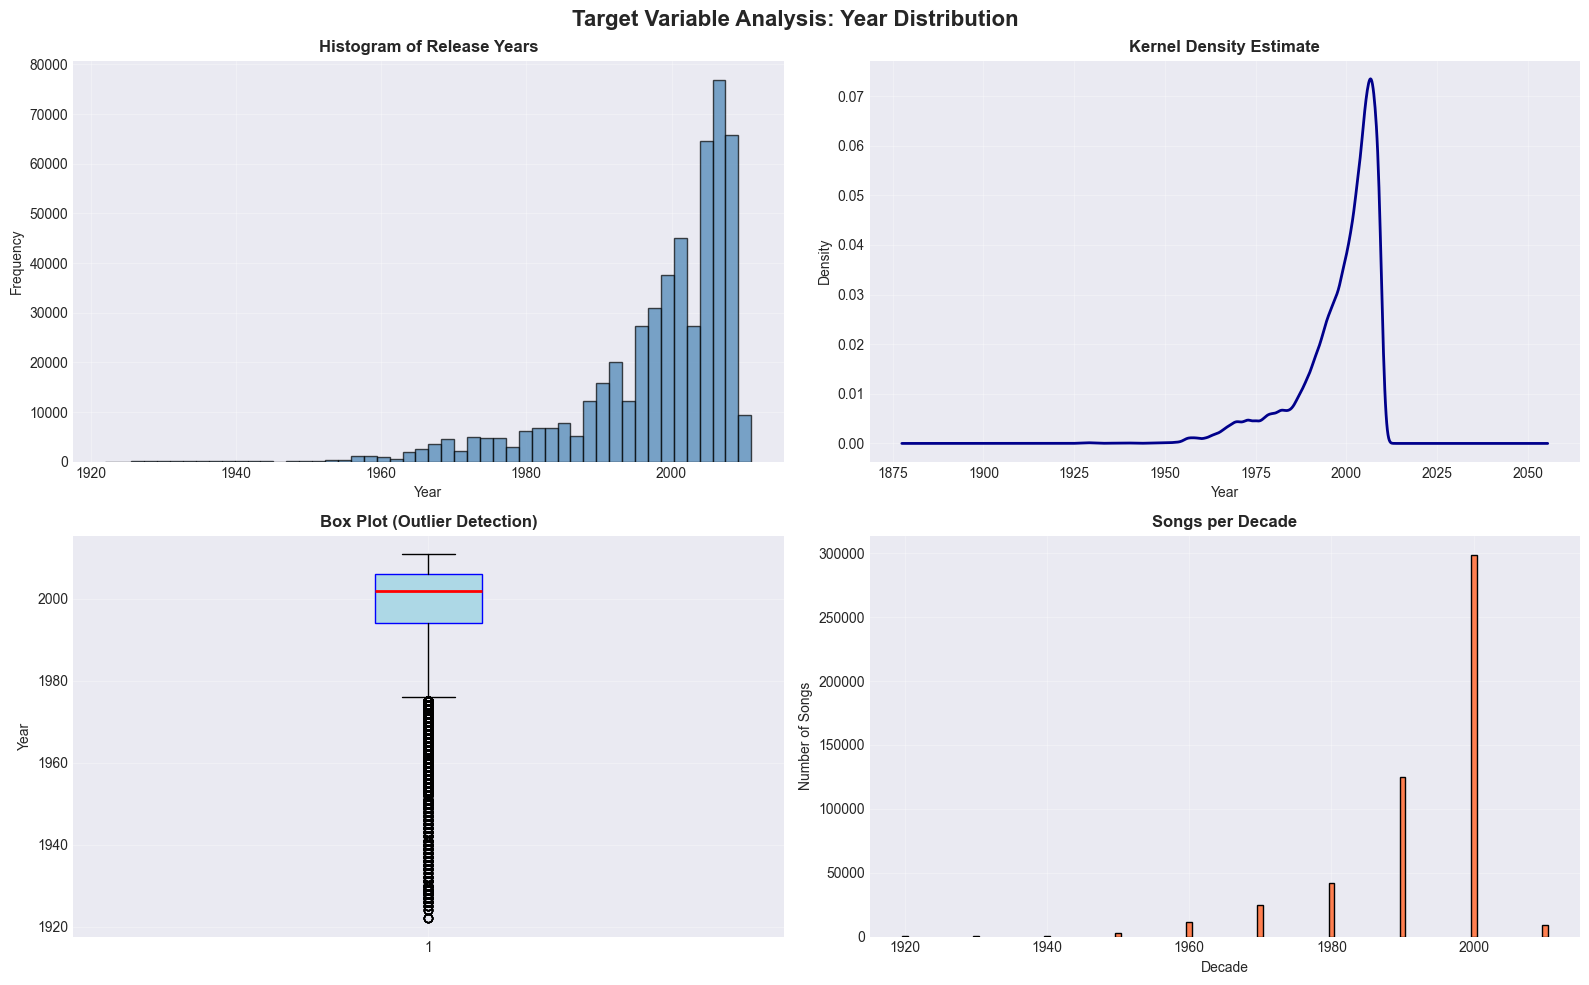


📊 FEATURE DISTRIBUTION ANALYSIS
--------------------------------------------------------------------------------

Feature Statistics Summary:
               count     mean      std       min      25%      50%      75%  \
feature_1   515345.0  43.3871   6.0676    1.7490  39.9547  44.2585  47.8339   
feature_2   515345.0   1.2896  51.5804 -337.0925 -26.0595   8.4178  36.1240   
feature_3   515345.0   8.6583  35.2686 -301.0051 -11.4627  10.4763  29.7648   
feature_4   515345.0   1.1641  16.3228 -154.1836  -8.4875  -0.6528   8.7875   
feature_5   515345.0  -6.5536  22.8608 -181.9534 -20.6665  -6.0078   7.7419   
feature_6   515345.0  -9.5220  12.8578  -81.7943 -18.4410 -11.1884  -2.3890   
feature_7   515345.0  -2.3911  14.5719 -188.2140 -10.7806  -2.0467   6.5086   
feature_8   515345.0  -1.7932   7.9638  -72.5038  -6.4684  -1.7365   2.9135   
feature_9   515345.0   3.7279  10.5829 -126.4790  -2.2937   3.8223   9.9618   
feature_10  515345.0   1.8824   6.5302  -41.6317  -2.4449   1.7835 

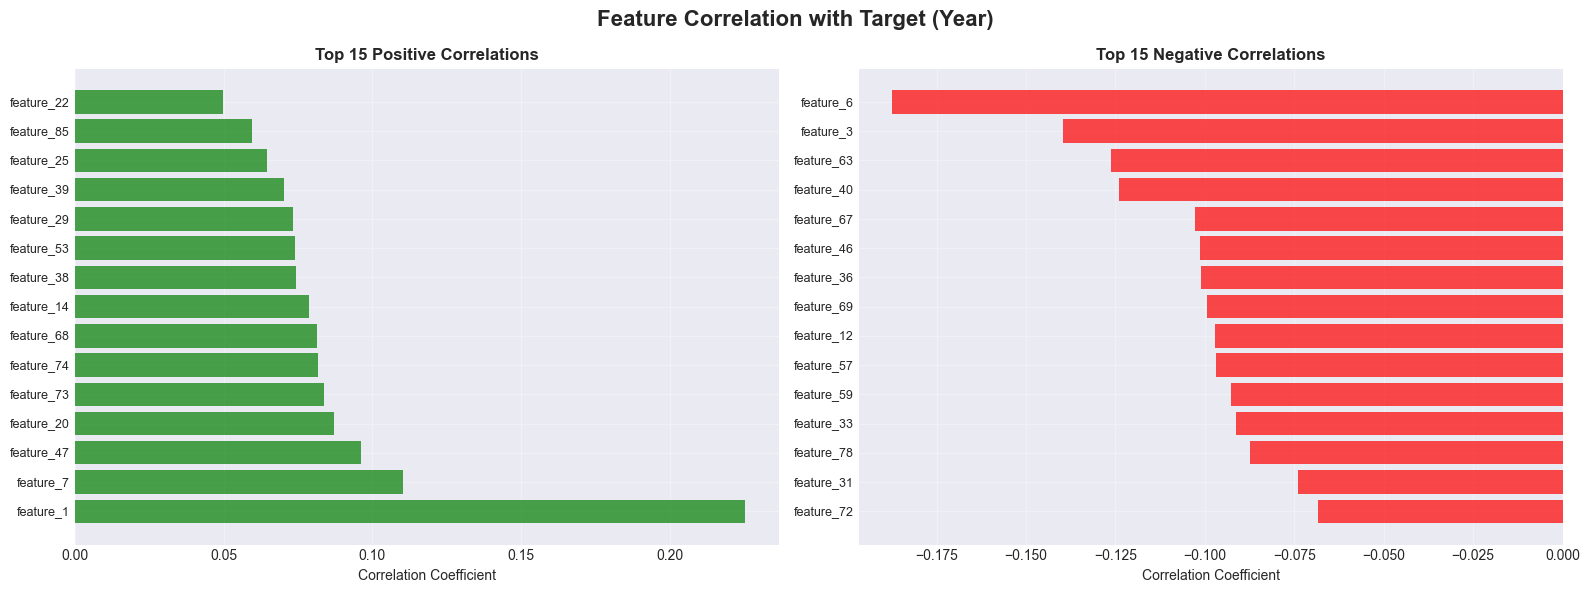


 CORRELATION MATRIX (Top 20 Features)
--------------------------------------------------------------------------------


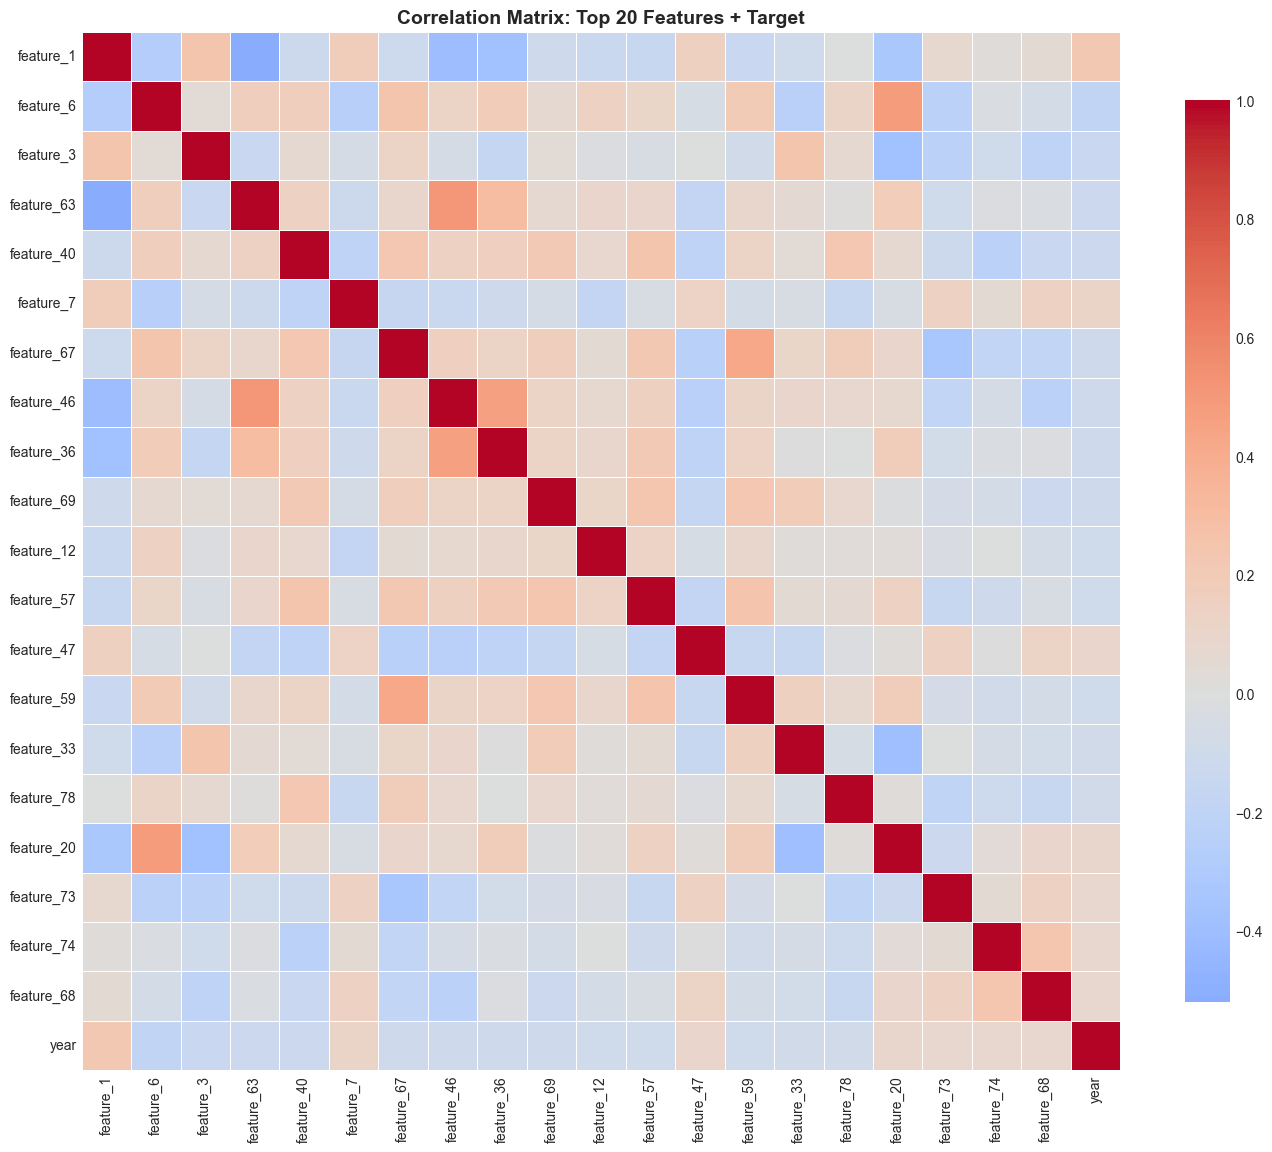


 EDA Completed!


In [4]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# ============== TARGET VARIABLE ANALYSIS ==============
print("\n TARGET VARIABLE ANALYSIS (YEAR)")
print("-"*80)

target_stats = df_raw['year'].describe()
print(target_stats)

print(f"\n Year Range: {df_raw['year'].min()} - {df_raw['year'].max()}")
print(f" Year Span: {df_raw['year'].max() - df_raw['year'].min()} years")
print(f" Unique Years: {df_raw['year'].nunique()}")

# ============== VISUALIZATION: TARGET DISTRIBUTION ==============
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Target Variable Analysis: Year Distribution', fontsize=16, fontweight='bold')

# 1. Histogram with KDE
axes[0, 0].hist(df_raw['year'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Histogram of Release Years', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. KDE Plot
df_raw['year'].plot(kind='kde', ax=axes[0, 1], color='darkblue', linewidth=2)
axes[0, 1].set_title('Kernel Density Estimate', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].grid(True, alpha=0.3)

# 3. Box Plot
axes[1, 0].boxplot(df_raw['year'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_title('Box Plot (Outlier Detection)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Year')
axes[1, 0].grid(True, alpha=0.3)

# 4. Value Counts per Decade
df_raw['decade'] = (df_raw['year'] // 10) * 10
decade_counts = df_raw['decade'].value_counts().sort_index()
axes[1, 1].bar(decade_counts.index, decade_counts.values, color='coral', edgecolor='black')
axes[1, 1].set_title('Songs per Decade', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Decade')
axes[1, 1].set_ylabel('Number of Songs')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}01_target_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Drop temporary decade column
df_raw.drop('decade', axis=1, inplace=True)

# ============== FEATURE DISTRIBUTION ANALYSIS ==============
print("\n📊 FEATURE DISTRIBUTION ANALYSIS")
print("-"*80)

feature_cols = [col for col in df_raw.columns if col != 'year']

# Statistical summary of features
feature_stats = df_raw[feature_cols].describe().T
print("\nFeature Statistics Summary:")
print(feature_stats.head(10))

# ============== CORRELATION ANALYSIS ==============
print("\n🔗 CORRELATION ANALYSIS")
print("-"*80)

# Compute correlation with target
correlations = df_raw[feature_cols].corrwith(df_raw['year']).sort_values(ascending=False)

print("\nTop 10 Features with HIGHEST positive correlation:")
print(correlations.head(10))

print("\nTop 10 Features with HIGHEST negative correlation:")
print(correlations.tail(10))

# Visualization: Top correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Correlation with Target (Year)', fontsize=16, fontweight='bold')

# Positive correlations
top_pos = correlations.head(15)
axes[0].barh(range(len(top_pos)), top_pos.values, color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_pos)))
axes[0].set_yticklabels(top_pos.index, fontsize=9)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('Top 15 Positive Correlations', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Negative correlations
top_neg = correlations.tail(15)
axes[1].barh(range(len(top_neg)), top_neg.values, color='red', alpha=0.7)
axes[1].set_yticks(range(len(top_neg)))
axes[1].set_yticklabels(top_neg.index, fontsize=9)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Top 15 Negative Correlations', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}02_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# ============== CORRELATION MATRIX (TOP FEATURES) ==============
print("\n CORRELATION MATRIX (Top 20 Features)")
print("-"*80)

# Select top 20 features by absolute correlation
top_features = correlations.abs().sort_values(ascending=False).head(20).index.tolist()
corr_matrix = df_raw[top_features + ['year']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Top 20 Features + Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}03_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n EDA Completed!")

SECTION 3: DATA QUALITY CHECK & CLEANING


DATA QUALITY ASSESSMENT

1️. MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------
✅ NO MISSING VALUES DETECTED!

2️. DUPLICATE ROWS DETECTION
--------------------------------------------------------------------------------
Duplicate Rows: 214 (0.0415%)
⚠️  Removing 214 duplicate rows...
✅ Dataset after removing duplicates: (515131, 91)

3️. OUTLIER DETECTION (Z-Score Method)
--------------------------------------------------------------------------------
Total rows with at least one outlier (Z-score > 4): 71,189 (13.82%)

Top 10 Features with Most Outliers:
  feature_68     : 4,573 outliers (0.888%)
  feature_37     : 4,221 outliers (0.819%)
  feature_27     : 4,087 outliers (0.793%)
  feature_55     : 4,078 outliers (0.792%)
  feature_77     : 3,975 outliers (0.772%)
  feature_26     : 3,879 outliers (0.753%)
  feature_14     : 3,873 outliers (0.752%)
  feature_20     : 3,872 outliers (0.752%)
  feature_81     : 3,859 outliers (0.74

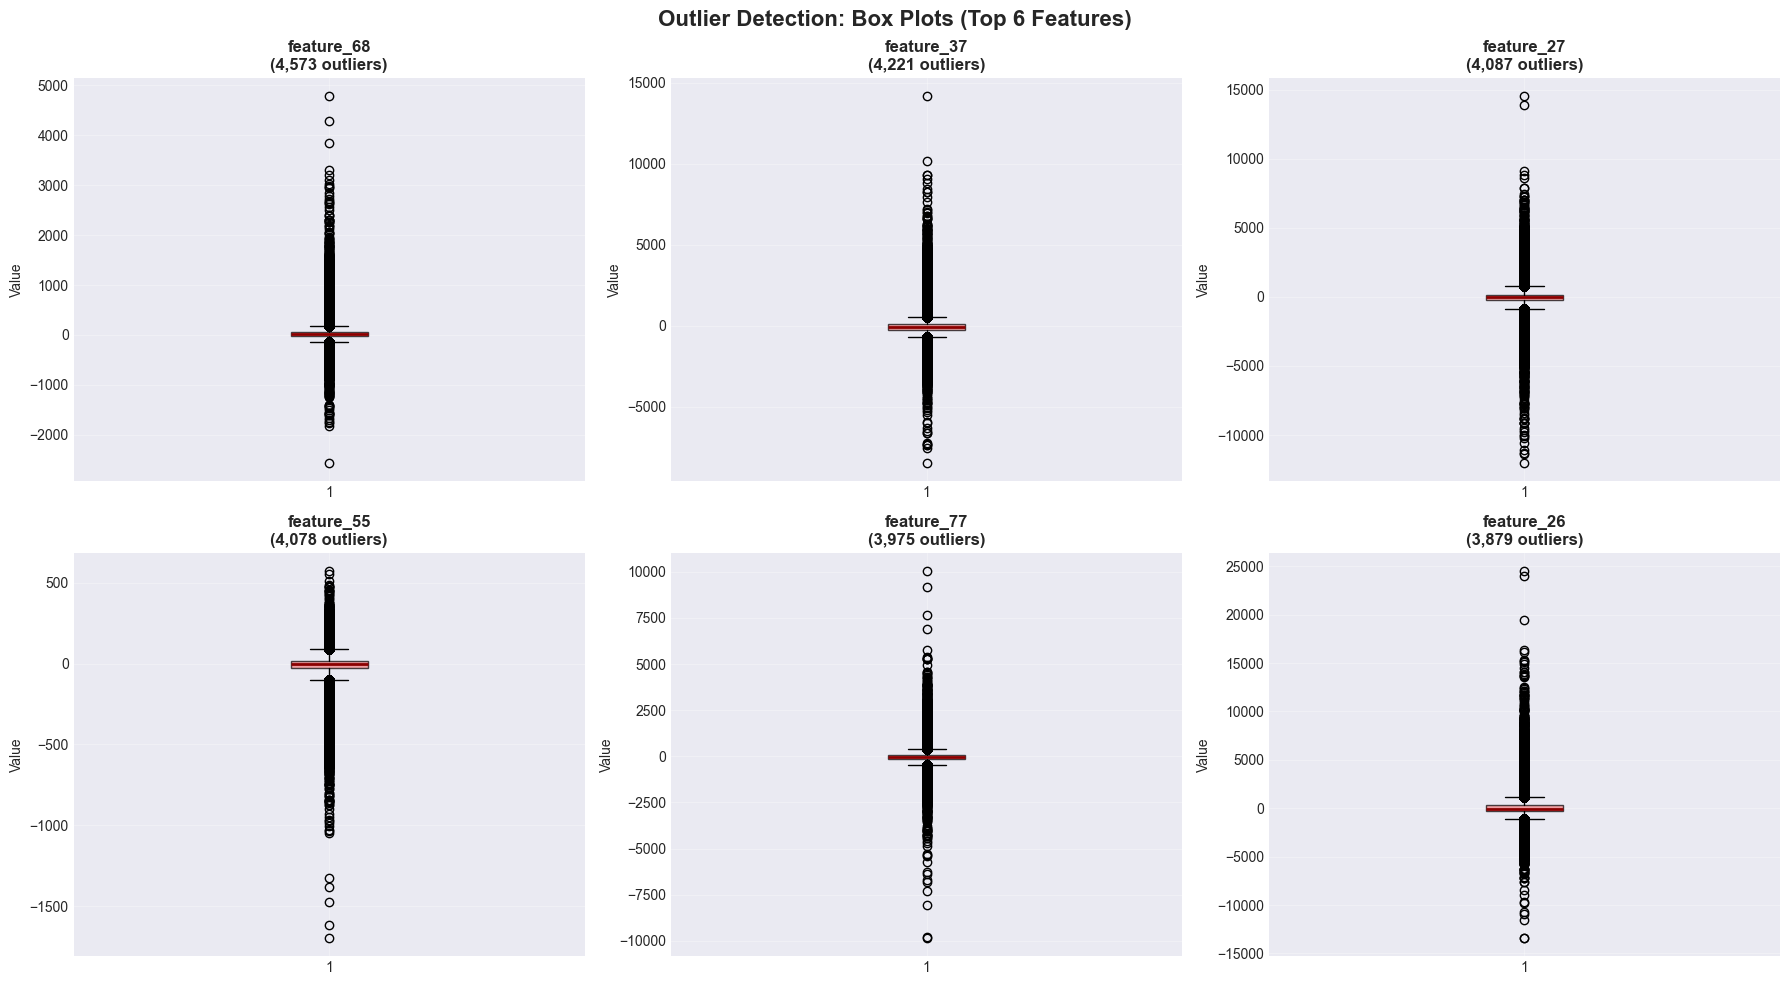


  DECISION: Keeping outliers (audio features can have natural extremes)
Will use RobustScaler for preprocessing to handle outliers

FINAL CLEAN DATASET SUMMARY

Original Shape: (515345, 91)
After Cleaning: (515131, 91)
Rows Removed  : 214

 Data Quality Check Completed!


In [5]:
print("\n" + "="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

# ============== MISSING VALUES CHECK ==============
print("\n1️. MISSING VALUES ANALYSIS")
print("-"*80)

missing_count = df_raw.isnull().sum()
missing_percent = (df_raw.isnull().sum() / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_count,
    'Missing_Percent': missing_percent
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"⚠️  Found {len(missing_df)} columns with missing values:")
    print(missing_df)
else:
    print("✅ NO MISSING VALUES DETECTED!")

# ============== DUPLICATE DETECTION ==============
print("\n2️. DUPLICATE ROWS DETECTION")
print("-"*80)

duplicate_count = df_raw.duplicated().sum()
print(f"Duplicate Rows: {duplicate_count:,} ({duplicate_count/len(df_raw)*100:.4f}%)")

if duplicate_count > 0:
    print(f"⚠️  Removing {duplicate_count:,} duplicate rows...")
    df_clean = df_raw.drop_duplicates()
    print(f"✅ Dataset after removing duplicates: {df_clean.shape}")
else:
    df_clean = df_raw.copy()
    print(" No duplicates found!")

# ============== OUTLIER DETECTION (Z-SCORE METHOD) ==============
print("\n3️. OUTLIER DETECTION (Z-Score Method)")
print("-"*80)

# We'll use Z-score with threshold of 4 (more conservative than 3)
# because audio features can naturally have wide ranges
# FIX: Keep as DataFrame to maintain column names
numeric_cols = df_clean.select_dtypes(include=[np.number])
z_scores_df = pd.DataFrame(
    np.abs(stats.zscore(numeric_cols, nan_policy='omit')),
    columns=numeric_cols.columns,
    index=numeric_cols.index
)

outlier_threshold = 4

# Count outliers per column
outlier_counts = (z_scores_df > outlier_threshold).sum(axis=0)
total_outliers = (z_scores_df > outlier_threshold).any(axis=1).sum()

print(f"Total rows with at least one outlier (Z-score > {outlier_threshold}): {total_outliers:,} ({total_outliers/len(df_clean)*100:.2f}%)")

# Show top 10 features with most outliers
print("\nTop 10 Features with Most Outliers:")
top_outliers = outlier_counts.sort_values(ascending=False).head(10)
for feat, count in top_outliers.items():
    print(f"  {feat:15s}: {count:,} outliers ({count/len(df_clean)*100:.3f}%)")

# ============== OUTLIER VISUALIZATION ==============
print("\n Visualizing Outliers (Top 6 Features)")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Outlier Detection: Box Plots (Top 6 Features)', fontsize=16, fontweight='bold')

top_6_outlier_features = outlier_counts.sort_values(ascending=False).head(6).index.tolist()

for idx, feat in enumerate(top_6_outlier_features):
    row = idx // 3
    col = idx % 3

    axes[row, col].boxplot(df_clean[feat], vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightcoral', alpha=0.7),
                            medianprops=dict(color='darkred', linewidth=2))
    axes[row, col].set_title(f'{feat}\n({outlier_counts[feat]:,} outliers)', fontweight='bold')
    axes[row, col].set_ylabel('Value')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}04_outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n  DECISION: Keeping outliers (audio features can have natural extremes)")
print("Will use RobustScaler for preprocessing to handle outliers")

# ============== FINAL CLEAN DATASET INFO ==============
print("\n" + "="*80)
print("FINAL CLEAN DATASET SUMMARY")
print("="*80)

print(f"\nOriginal Shape: {df_raw.shape}")
print(f"After Cleaning: {df_clean.shape}")
print(f"Rows Removed  : {len(df_raw) - len(df_clean):,}")

print("\n Data Quality Check Completed!")

SECTION 4: FEATURE ENGINEERING

In [6]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Create a copy for feature engineering
df_fe = df_clean.copy()

# ============== 1. POLYNOMIAL FEATURES (TOP CORRELATED) ==============
print("\n1️. CREATING POLYNOMIAL FEATURES (Top Correlated)")
print("-"*80)

# Get top 10 most correlated features (absolute value)
feature_cols = [col for col in df_fe.columns if col != 'year']
correlations_abs = df_fe[feature_cols].corrwith(df_fe['year']).abs().sort_values(ascending=False)
top_features = correlations_abs.head(10).index.tolist()

print(f"Top 10 features for polynomial engineering:")
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat:15s}: {correlations_abs[feat]:.4f}")

# Create squared terms for top features
for feat in top_features[:5]:  # Only top 5 to avoid dimensionality explosion
    df_fe[f'{feat}_squared'] = df_fe[feat] ** 2
    print(f"Created: {feat}_squared")

print(f"\n Dataset shape after polynomial features: {df_fe.shape}")

# ============== 2. INTERACTION FEATURES ==============
print("\n2️. CREATING INTERACTION FEATURES")
print("-"*80)

# Create interactions between top 3 features
interaction_pairs = [
    (top_features[0], top_features[1]),
    (top_features[0], top_features[2]),
    (top_features[1], top_features[2])
]

for feat1, feat2 in interaction_pairs:
    new_col = f'{feat1}_X_{feat2}'
    df_fe[new_col] = df_fe[feat1] * df_fe[feat2]
    print(f"Created: {new_col}")

print(f"\n Dataset shape after interaction features: {df_fe.shape}")

# ============== 3. STATISTICAL AGGREGATIONS ==============
print("\n3️. CREATING STATISTICAL AGGREGATION FEATURES")
print("-"*80)

# Create groups of features for aggregation
feature_groups = {
    'features_1_30': [f'feature_{i}' for i in range(1, 31)],
    'features_31_60': [f'feature_{i}' for i in range(31, 61)],
    'features_61_90': [f'feature_{i}' for i in range(61, 91)]
}

for group_name, features in feature_groups.items():
    # Mean
    df_fe[f'{group_name}_mean'] = df_fe[features].mean(axis=1)

    # Standard deviation
    df_fe[f'{group_name}_std'] = df_fe[features].std(axis=1)

    # Min and Max
    df_fe[f'{group_name}_min'] = df_fe[features].min(axis=1)
    df_fe[f'{group_name}_max'] = df_fe[features].max(axis=1)

    # Range
    df_fe[f'{group_name}_range'] = df_fe[f'{group_name}_max'] - df_fe[f'{group_name}_min']

    print(f"Created 5 aggregation features for {group_name}")

print(f"\n Dataset shape after aggregation features: {df_fe.shape}")

# ============== 4. FEATURE SELECTION (REMOVE LOW VARIANCE) ==============
print("\n4️. FEATURE SELECTION: REMOVING LOW VARIANCE FEATURES")
print("-"*80)

from sklearn.feature_selection import VarianceThreshold

# Separate features and target
X_fe = df_fe.drop('year', axis=1)
y_fe = df_fe['year']

# Calculate variance
variances = X_fe.var()
low_variance_features = variances[variances < 0.01].index.tolist()

print(f"Features with variance < 0.01: {len(low_variance_features)}")
if len(low_variance_features) > 0:
    print(f"Removing {len(low_variance_features)} low-variance features...")
    X_fe = X_fe.drop(columns=low_variance_features)
    print(f"Remaining features: {X_fe.shape[1]}")
else:
    print("No low-variance features to remove!")

# ============== 5. CORRELATION-BASED FEATURE SELECTION ==============
print("\n5️. REMOVING HIGHLY CORRELATED FEATURES (Multicollinearity)")
print("-"*80)

# Calculate correlation matrix
corr_matrix = X_fe.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

print(f"Features with correlation > 0.95: {len(to_drop)}")
if len(to_drop) > 0:
    print(f"Removing {len(to_drop)} highly correlated features...")
    X_fe = X_fe.drop(columns=to_drop)
    print(f"Remaining features: {X_fe.shape[1]}")
else:
    print("No highly correlated features to remove!")

# Combine back with target
df_fe_final = pd.concat([y_fe.reset_index(drop=True), X_fe.reset_index(drop=True)], axis=1)

# ============== FINAL FEATURE ENGINEERING SUMMARY ==============
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\n Original Features: {len(df_clean.columns) - 1}")
print(f" After Engineering: {len(df_fe_final.columns) - 1}")
print(f" Features Added: {len(df_fe_final.columns) - len(df_clean.columns)}")
print(f" Final Dataset Shape: {df_fe_final.shape}")

print("\n Feature Engineering Completed!")

# Save for next steps
df_final = df_fe_final.copy()


FEATURE ENGINEERING

1️. CREATING POLYNOMIAL FEATURES (Top Correlated)
--------------------------------------------------------------------------------
Top 10 features for polynomial engineering:
  1. feature_1      : 0.2253
  2. feature_6      : 0.1874
  3. feature_3      : 0.1396
  4. feature_63     : 0.1263
  5. feature_40     : 0.1240
  6. feature_7      : 0.1105
  7. feature_67     : 0.1028
  8. feature_46     : 0.1013
  9. feature_36     : 0.1011
  10. feature_69     : 0.0995
Created: feature_1_squared
Created: feature_6_squared
Created: feature_3_squared
Created: feature_63_squared
Created: feature_40_squared

 Dataset shape after polynomial features: (515131, 96)

2️. CREATING INTERACTION FEATURES
--------------------------------------------------------------------------------
Created: feature_1_X_feature_6
Created: feature_1_X_feature_3
Created: feature_6_X_feature_3

 Dataset shape after interaction features: (515131, 99)

3️. CREATING STATISTICAL AGGREGATION FEATURES
------

SECTION 5: DATA SPLITTING & ADVANCED SCALING

In [7]:
print("\n" + "="*80)
print("DATA SPLITTING & SCALING")
print("="*80)

# ============== SEPARATE FEATURES AND TARGET ==============
X = df_final.drop('year', axis=1)
y = df_final['year']

print(f"\n📊 Feature Matrix (X): {X.shape}")
print(f"🎯 Target Vector (y): {y.shape}")

# ============== TRAIN-TEST SPLIT ==============
print("\n1️. SPLITTING DATA (80% Train, 20% Test)")
print("-"*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True  # Ensure random shuffling
)

print(f"✅ Training Set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✅ Test Set    : {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check target distribution in train/test
print("\n📊 Target Distribution Check:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

# ============== ADVANCED SCALING ==============
print("\n2️. FEATURE SCALING (RobustScaler - Outlier Resistant)")
print("-"*80)

# RobustScaler is better for data with outliers
# It uses median and IQR instead of mean and std
scaler = RobustScaler()

# FIT only on training data
print("Fitting scaler on training data...")
scaler.fit(X_train)

# TRANSFORM both train and test
print("Transforming train and test sets...")
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✅ Scaling completed!")

# ============== SAVE PROCESSED DATA ==============
print("\n3️. SAVING PROCESSED DATA TO DISK")
print("-"*80)

# Create train and test dataframes with target
train_processed = pd.concat([y_train.reset_index(drop=True), X_train_scaled.reset_index(drop=True)], axis=1)
test_processed = pd.concat([y_test.reset_index(drop=True), X_test_scaled.reset_index(drop=True)], axis=1)

# Save paths
train_save_path = f'{SAVE_DIR}train_processed_v2.csv'
test_save_path = f'{SAVE_DIR}test_processed_v2.csv'
scaler_save_path = f'{SAVE_DIR}scaler_v2.pkl'

# Save to CSV
print(f"Saving training data to: {train_save_path}")
train_processed.to_csv(train_save_path, index=False)

print(f"Saving test data to: {test_save_path}")
test_processed.to_csv(test_save_path, index=False)

# Save scaler for future use
print(f"Saving scaler to: {scaler_save_path}")
joblib.dump(scaler, scaler_save_path)

print("\n✅ All processed data saved successfully!")

# ============== VERIFICATION ==============
print("\n4️. VERIFICATION")
print("-"*80)

print("\nScaled data statistics (Train):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].T.head(10))

print("\n✅ Data Splitting & Scaling Completed!")
print("="*80)


DATA SPLITTING & SCALING

📊 Feature Matrix (X): (515131, 106)
🎯 Target Vector (y): (515131,)

1️. SPLITTING DATA (80% Train, 20% Test)
--------------------------------------------------------------------------------
✅ Training Set: 412,104 samples (80.0%)
✅ Test Set    : 103,027 samples (20.0%)

📊 Target Distribution Check:
Train - Mean: 1998.39, Std: 10.95
Test  - Mean: 1998.44, Std: 10.85

2️. FEATURE SCALING (RobustScaler - Outlier Resistant)
--------------------------------------------------------------------------------
Fitting scaler on training data...
Transforming train and test sets...
✅ Scaling completed!

3️. SAVING PROCESSED DATA TO DISK
--------------------------------------------------------------------------------
Saving training data to: d:\Finalterm_ML\regresitrain_processed_v2.csv
Saving test data to: d:\Finalterm_ML\regresitest_processed_v2.csv
Saving scaler to: d:\Finalterm_ML\regresiscaler_v2.pkl

✅ All processed data saved successfully!

4️. VERIFICATION
--------

SECTION 6: BASELINE MODELS - LINEAR APPROACHES

In [8]:
print("\n" + "="*80)
print("BASELINE MODELS TRAINING")
print("="*80)

# ============== LOAD PROCESSED DATA ==============
print("\n📂 Loading processed data...")

train_processed = pd.read_csv(f'{SAVE_DIR}train_processed_v2.csv')
test_processed = pd.read_csv(f'{SAVE_DIR}test_processed_v2.csv')

X_train = train_processed.drop('year', axis=1)
y_train = train_processed['year']
X_test = test_processed.drop('year', axis=1)
y_test = test_processed['year']

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")

# ============== EVALUATION FUNCTION ==============
def evaluate_model(model_name, y_true, y_pred, train_time=None):
    """Comprehensive model evaluation"""

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Adjusted R2
    n = len(y_true)
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"\n{'='*80}")
    print(f"MODEL: {model_name}")
    print(f"{'='*80}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f} years")
    print(f"MAE  (Mean Absolute Error)    : {mae:.4f} years")
    print(f"MAPE (Mean Absolute % Error)  : {mape:.4f}%")
    print(f"R²   (Coefficient of Determination): {r2:.4f}")
    print(f"Adjusted R²                   : {adj_r2:.4f}")

    if train_time:
        print(f"Training Time                 : {train_time:.2f} seconds")

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Adj_R2': adj_r2,
        'Train_Time': train_time
    }

# Store results
results = []

# ============== MODEL 1: LINEAR REGRESSION ==============
print("\n" + "="*80)
print("🔵 MODEL 1: LINEAR REGRESSION (Ordinary Least Squares)")
print("="*80)

start_time = time.time()
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("Linear Regression (Train)", y_train, y_pred_lr_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("Linear Regression (Test)", y_test, y_pred_lr_test))

# ============== MODEL 2: RIDGE REGRESSION ==============
print("\n" + "="*80)
print("🔵 MODEL 2: RIDGE REGRESSION (L2 Regularization)")
print("="*80)

start_time = time.time()
ridge_model = Ridge(alpha=10.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_ridge_train = ridge_model.predict(X_train)
y_pred_ridge_test = ridge_model.predict(X_test)

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("Ridge Regression (Train)", y_train, y_pred_ridge_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("Ridge Regression (Test)", y_test, y_pred_ridge_test))

# ============== MODEL 3: LASSO REGRESSION ==============
print("\n" + "="*80)
print("🔵 MODEL 3: LASSO REGRESSION (L1 Regularization)")
print("="*80)

start_time = time.time()
lasso_model = Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=5000)
lasso_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_lasso_train = lasso_model.predict(X_train)
y_pred_lasso_test = lasso_model.predict(X_test)

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("Lasso Regression (Train)", y_train, y_pred_lasso_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("Lasso Regression (Test)", y_test, y_pred_lasso_test))

# ============== BASELINE SUMMARY ==============
print("\n" + "="*80)
print("BASELINE MODELS SUMMARY")
print("="*80)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Save baseline results
results_df.to_csv(f'{SAVE_DIR}baseline_results.csv', index=False)

print("\n✅ Baseline Models Training Completed!")


BASELINE MODELS TRAINING

📂 Loading processed data...
✅ Train: (412104, 106), Test: (103027, 106)

🔵 MODEL 1: LINEAR REGRESSION (Ordinary Least Squares)

📊 TRAINING SET PERFORMANCE:

MODEL: Linear Regression (Train)
RMSE (Root Mean Squared Error): 9.5299 years
MAE  (Mean Absolute Error)    : 6.7924 years
MAPE (Mean Absolute % Error)  : 0.3411%
R²   (Coefficient of Determination): 0.2429
Adjusted R²                   : 0.2427
Training Time                 : 7.02 seconds

📊 TEST SET PERFORMANCE:

MODEL: Linear Regression (Test)
RMSE (Root Mean Squared Error): 9.4554 years
MAE  (Mean Absolute Error)    : 6.7602 years
MAPE (Mean Absolute % Error)  : 0.3394%
R²   (Coefficient of Determination): 0.2403
Adjusted R²                   : 0.2395

🔵 MODEL 2: RIDGE REGRESSION (L2 Regularization)

📊 TRAINING SET PERFORMANCE:

MODEL: Ridge Regression (Train)
RMSE (Root Mean Squared Error): 9.5299 years
MAE  (Mean Absolute Error)    : 6.7925 years
MAPE (Mean Absolute % Error)  : 0.3411%
R²   (Coeffic

SECTION 7: ADVANCED MACHINE LEARNING MODELS


ADVANCED ML MODELS TRAINING

🌲 MODEL 4: RANDOM FOREST REGRESSOR

📊 TRAINING SET PERFORMANCE:

MODEL: Random Forest (Train)
RMSE (Root Mean Squared Error): 6.4503 years
MAE  (Mean Absolute Error)    : 4.5543 years
MAPE (Mean Absolute % Error)  : 0.2287%
R²   (Coefficient of Determination): 0.6531
Adjusted R²                   : 0.6531
Training Time                 : 124.58 seconds

📊 TEST SET PERFORMANCE:

MODEL: Random Forest (Test)
RMSE (Root Mean Squared Error): 9.1804 years
MAE  (Mean Absolute Error)    : 6.6101 years
MAPE (Mean Absolute % Error)  : 0.3319%
R²   (Coefficient of Determination): 0.2839
Adjusted R²                   : 0.2831

🚀 MODEL 5: GRADIENT BOOSTING REGRESSOR

📊 TRAINING SET PERFORMANCE:

MODEL: Gradient Boosting (Train)
RMSE (Root Mean Squared Error): 8.5518 years
MAE  (Mean Absolute Error)    : 6.0190 years
MAPE (Mean Absolute % Error)  : 0.3022%
R²   (Coefficient of Determination): 0.3903
Adjusted R²                   : 0.3902
Training Time                 : 4

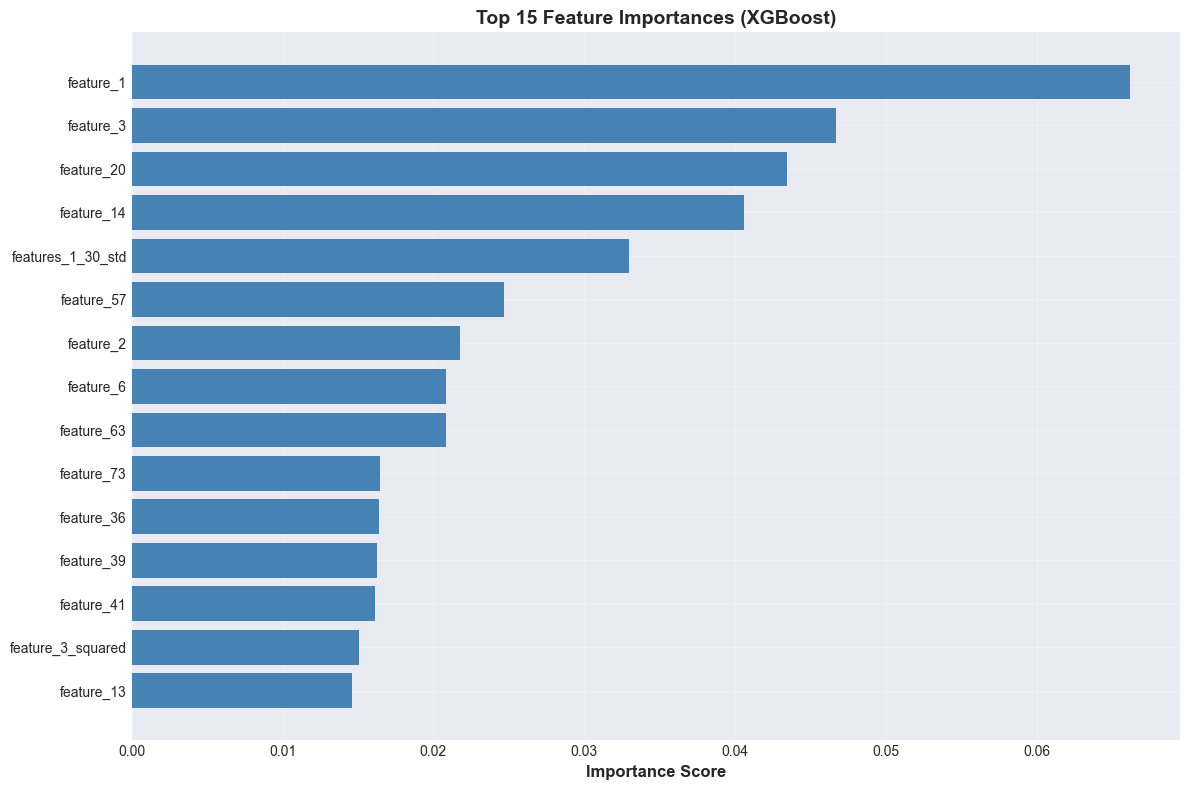


✅ Advanced ML Models Training Completed!


In [9]:
print("\n" + "="*80)
print("ADVANCED ML MODELS TRAINING")
print("="*80)

# ============== MODEL 4: RANDOM FOREST ==============
print("\n" + "="*80)
print("🌲 MODEL 4: RANDOM FOREST REGRESSOR")
print("="*80)

start_time = time.time()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0
)

rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("Random Forest (Train)", y_train, y_pred_rf_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("Random Forest (Test)", y_test, y_pred_rf_test))

# ============== MODEL 5: GRADIENT BOOSTING ==============
print("\n" + "="*80)
print("🚀 MODEL 5: GRADIENT BOOSTING REGRESSOR")
print("="*80)

start_time = time.time()
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=0
)

gb_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_gb_train = gb_model.predict(X_train)
y_pred_gb_test = gb_model.predict(X_test)

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("Gradient Boosting (Train)", y_train, y_pred_gb_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("Gradient Boosting (Test)", y_test, y_pred_gb_test))

# ============== MODEL 6: XGBOOST ==============
print("\n" + "="*80)
print("⚡ MODEL 6: XGBOOST REGRESSOR")
print("="*80)

start_time = time.time()
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    tree_method='hist'
)

xgb_model.fit(X_train, y_train, verbose=False)
train_time = time.time() - start_time

y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("XGBoost (Train)", y_train, y_pred_xgb_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("XGBoost (Test)", y_test, y_pred_xgb_test))

# ============== FEATURE IMPORTANCE (XGBOOST) ==============
print("\n📊 TOP 15 FEATURE IMPORTANCES (XGBoost)")
print("-"*80)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_15_features = feature_importance.head(15)
plt.barh(range(len(top_15_features)), top_15_features['Importance'].values, color='steelblue')
plt.yticks(range(len(top_15_features)), top_15_features['Feature'].values)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}05_feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Advanced ML Models Training Completed!")

SECTION 8: DEEP LEARNING - NEURAL NETWORK


DEEP LEARNING MODEL TRAINING

🧠 Building Deep Neural Network Architecture...


📊 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        54,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,913 (902.00 KB)

 Trainable params: 229,121 (895.00 KB)

 Non-trainable params: 1,792 (7.00 KB)


🚀 Starting Deep Learning Training...
This may take several minutes...
Epoch 1/100
1286/1288 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1912056.5000 - mae: 1140.4553 - mse: 1912056.5000
Epoch 1: val_loss improved from inf to 26199.77344, saving model to d:\Finalterm_ML\regresibest_dl_model.keras
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 1909438.3750 - mae: 1139.1786 - mse: 1909438.3750 - val_loss: 26199.7734 - val_mae: 116.5492 - val_mse: 26199.7734 - learning_rate: 0.0010
Epoch 2/100
1286/1288 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 63457.3711 - mae: 195.0647 - mse: 63457.3711
Epoch 2: val_loss improved from 26199.77344 to 6352.59082, saving model to d:\Finalterm_ML\regresibest_dl_model.keras
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 63445.5000 - mae: 195.0507 - mse: 63445.5000 - val_loss: 6352.5908 - val_mae: 70.6708 - val_mse: 6352.5908 - learning_rate: 0.0010
Epoch 3/100
1284/1288 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 50100.3828 - mae: 177.0677 - mse: 501

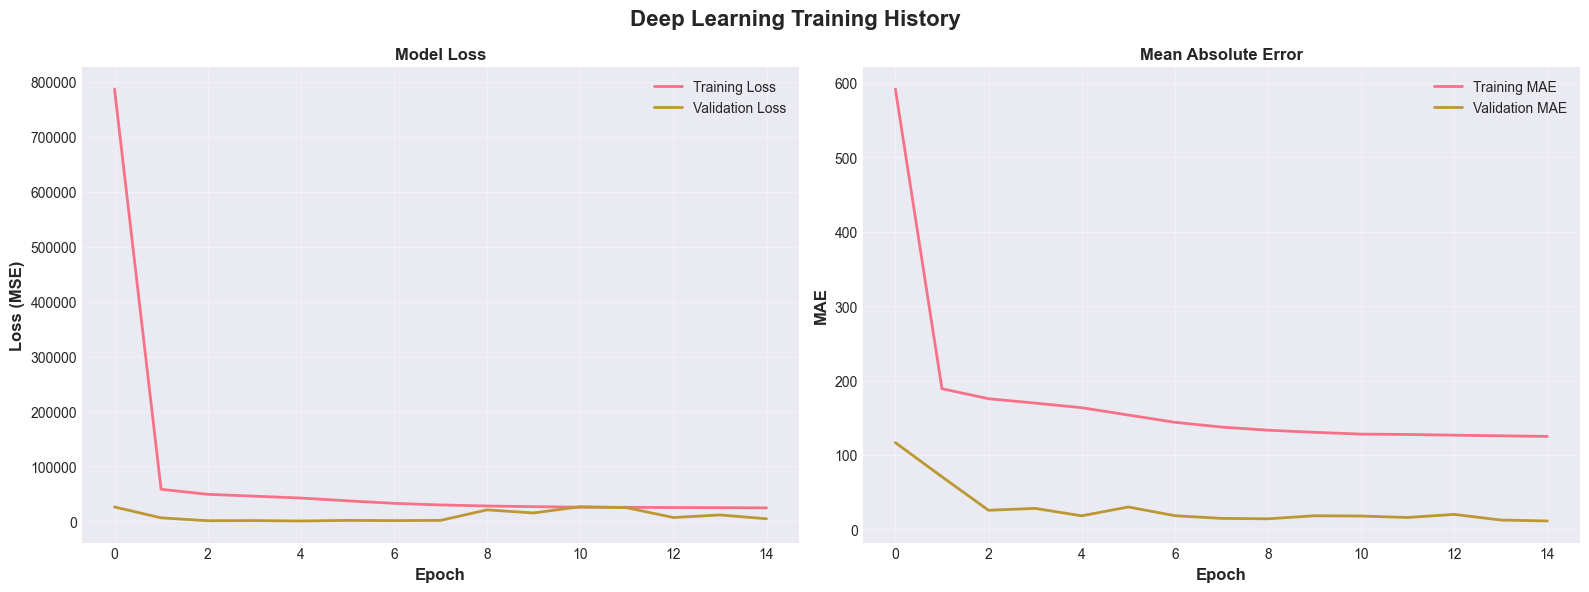


✅ Deep Learning Training Completed!


In [10]:
print("\n" + "="*80)
print("DEEP LEARNING MODEL TRAINING")
print("="*80)

# ============== BUILD OPTIMIZED NEURAL NETWORK ==============
print("\n🧠 Building Deep Neural Network Architecture...")

# Clear any previous models
tf.keras.backend.clear_session()

# Build model
dl_model = Sequential([
    Input(shape=(X_train.shape[1],)),

    # Layer 1: Large capacity for initial feature extraction
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 2: Intermediate representation
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 3: Further compression
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),

    # Layer 4: Fine-tuning layer
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),

    # Output Layer: Single neuron for regression
    Dense(1, activation='linear')
])

# ============== COMPILE MODEL ==============
optimizer = Adam(learning_rate=0.001)
dl_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Model summary
print("\n📊 Model Architecture:")
dl_model.summary()

# ============== CALLBACKS ==============
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    f'{SAVE_DIR}best_dl_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ============== TRAINING ==============
print("\n🚀 Starting Deep Learning Training...")
print("This may take several minutes...")

start_time = time.time()

history = dl_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

train_time = time.time() - start_time
print(f"\n✅ Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

# ============== EVALUATION ==============
y_pred_dl_train = dl_model.predict(X_train, verbose=0).flatten()
y_pred_dl_test = dl_model.predict(X_test, verbose=0).flatten()

print("\n📊 TRAINING SET PERFORMANCE:")
results.append(evaluate_model("Deep Learning (Train)", y_train, y_pred_dl_train, train_time))

print("\n📊 TEST SET PERFORMANCE:")
results.append(evaluate_model("Deep Learning (Test)", y_test, y_pred_dl_test))

# ============== TRAINING HISTORY VISUALIZATION ==============
print("\n📊 Visualizing Training History...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Deep Learning Training History', fontsize=16, fontweight='bold')

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}06_dl_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Deep Learning Training Completed!")

SECTION 9: HYPERPARAMETER TUNING - XGBOOST (RandomizedSearchCV)

In [17]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING - XGBOOST")
print("="*80)

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# LOAD DATA
# =========================================================
print("\n📂 Loading processed data for tuning...")
train_processed = pd.read_csv(f'{SAVE_DIR}train_processed_v2.csv')

X_train = train_processed.drop('year', axis=1)
y_train = train_processed['year']

# =========================================================
# PARAMETER DISTRIBUTIONS (DIPERKECIL BIAR HEMAT RAM)
# =========================================================
print("\n🎯 Setting up parameter search space...")

param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_lambda': [1.0, 1.5]
}

# =========================================================
# BASE MODEL (HEMAT MEMORY)
# =========================================================
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=RANDOM_STATE,
    verbosity=0
)

# =========================================================
# CV STRATEGY (LEBIH HEMAT RAM)
# =========================================================
cv_strategy = KFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

# =========================================================
# RANDOMIZED SEARCH (NO MULTIPROCESS)
# =========================================================
print("\n🔍 Starting RandomizedSearchCV...")
print("⚠️  n_jobs=1 to avoid MemoryError")

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=1          # ⬅️ INI KUNCI ANTI MEMORY ERROR
)

start_time = time.time()
random_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

print(f"\n✅ Tuning completed in {tuning_time/60:.2f} minutes")

# =========================================================
# BEST PARAMETERS
# =========================================================
print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND")
print("="*80)

best_params = random_search.best_params_
for k, v in best_params.items():
    print(f"{k:20s}: {v}")

print(f"\nBest CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")

# =========================================================
# SAVE MODEL
# =========================================================
xgb_tuned = random_search.best_estimator_

print("\n💾 Saving tuned model...")
joblib.dump(xgb_tuned, f'{SAVE_DIR}xgboost_tuned.pkl')

# =========================================================
# EVALUATION
# =========================================================
print("\n📊 Evaluating Tuned Model...")

test_processed = pd.read_csv(f'{SAVE_DIR}test_processed_v2.csv')
X_test = test_processed.drop('year', axis=1)
y_test = test_processed['year']

y_pred_train = xgb_tuned.predict(X_train)
y_pred_test = xgb_tuned.predict(X_test)

print("\n📊 TRAIN SET:")
results.append(
    evaluate_model("XGBoost Tuned (Train)", y_train, y_pred_train, tuning_time)
)

print("\n📊 TEST SET:")
results.append(
    evaluate_model("XGBoost Tuned (Test)", y_test, y_pred_test)
)

print("\n✅ Hyperparameter Tuning Completed!")



HYPERPARAMETER TUNING - XGBOOST

📂 Loading processed data for tuning...

🎯 Setting up parameter search space...

🔍 Starting RandomizedSearchCV...
⚠️  n_jobs=1 to avoid MemoryError
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1.0, subsample=0.8; total time=   9.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1.0, subsample=0.8; total time=   9.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, reg_lambda=1.0, subsample=0.8; total time=   9.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=150, reg_lambda=1.5, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=150, reg_lambda=1.5, subsample=0.8; total time=   8.9s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=150, reg_lambda=1.5, sub

SECTION 10: CROSS-VALIDATION & MODEL COMPARISON


CROSS-VALIDATION ANALYSIS

🔄 Running 5-Fold Cross-Validation on Top Models...

⏳ Linear Regression...
  RMSE: 9.5331 ± 0.0289

⏳ Ridge Regression...
  RMSE: 9.5331 ± 0.0289

⏳ XGBoost (Original)...
  RMSE: 8.8760 ± 0.0286

⏳ XGBoost (Tuned)...
  RMSE: 8.9025 ± 0.0274

CROSS-VALIDATION RESULTS SUMMARY
             Model  CV_RMSE_Mean  CV_RMSE_Std  CV_RMSE_Min  CV_RMSE_Max
 Linear Regression        9.5331       0.0289       9.5121       9.5903
  Ridge Regression        9.5331       0.0289       9.5121       9.5903
XGBoost (Original)        8.8760       0.0286       8.8397       8.9273
   XGBoost (Tuned)        8.9025       0.0274       8.8692       8.9500

COMPREHENSIVE MODEL COMPARISON (ALL MODELS)

📊 TEST SET RESULTS (Sorted by R²):
            Model    RMSE     MAE      R2   MAPE
          XGBoost  8.7772  6.1673  0.3454 0.3096
    XGBoost Tuned  8.8227  6.1931  0.3386 0.3109
Gradient Boosting  8.8914  6.2455  0.3282 0.3136
    Random Forest  9.1804  6.6101  0.2839 0.3319
 Ridge Regr

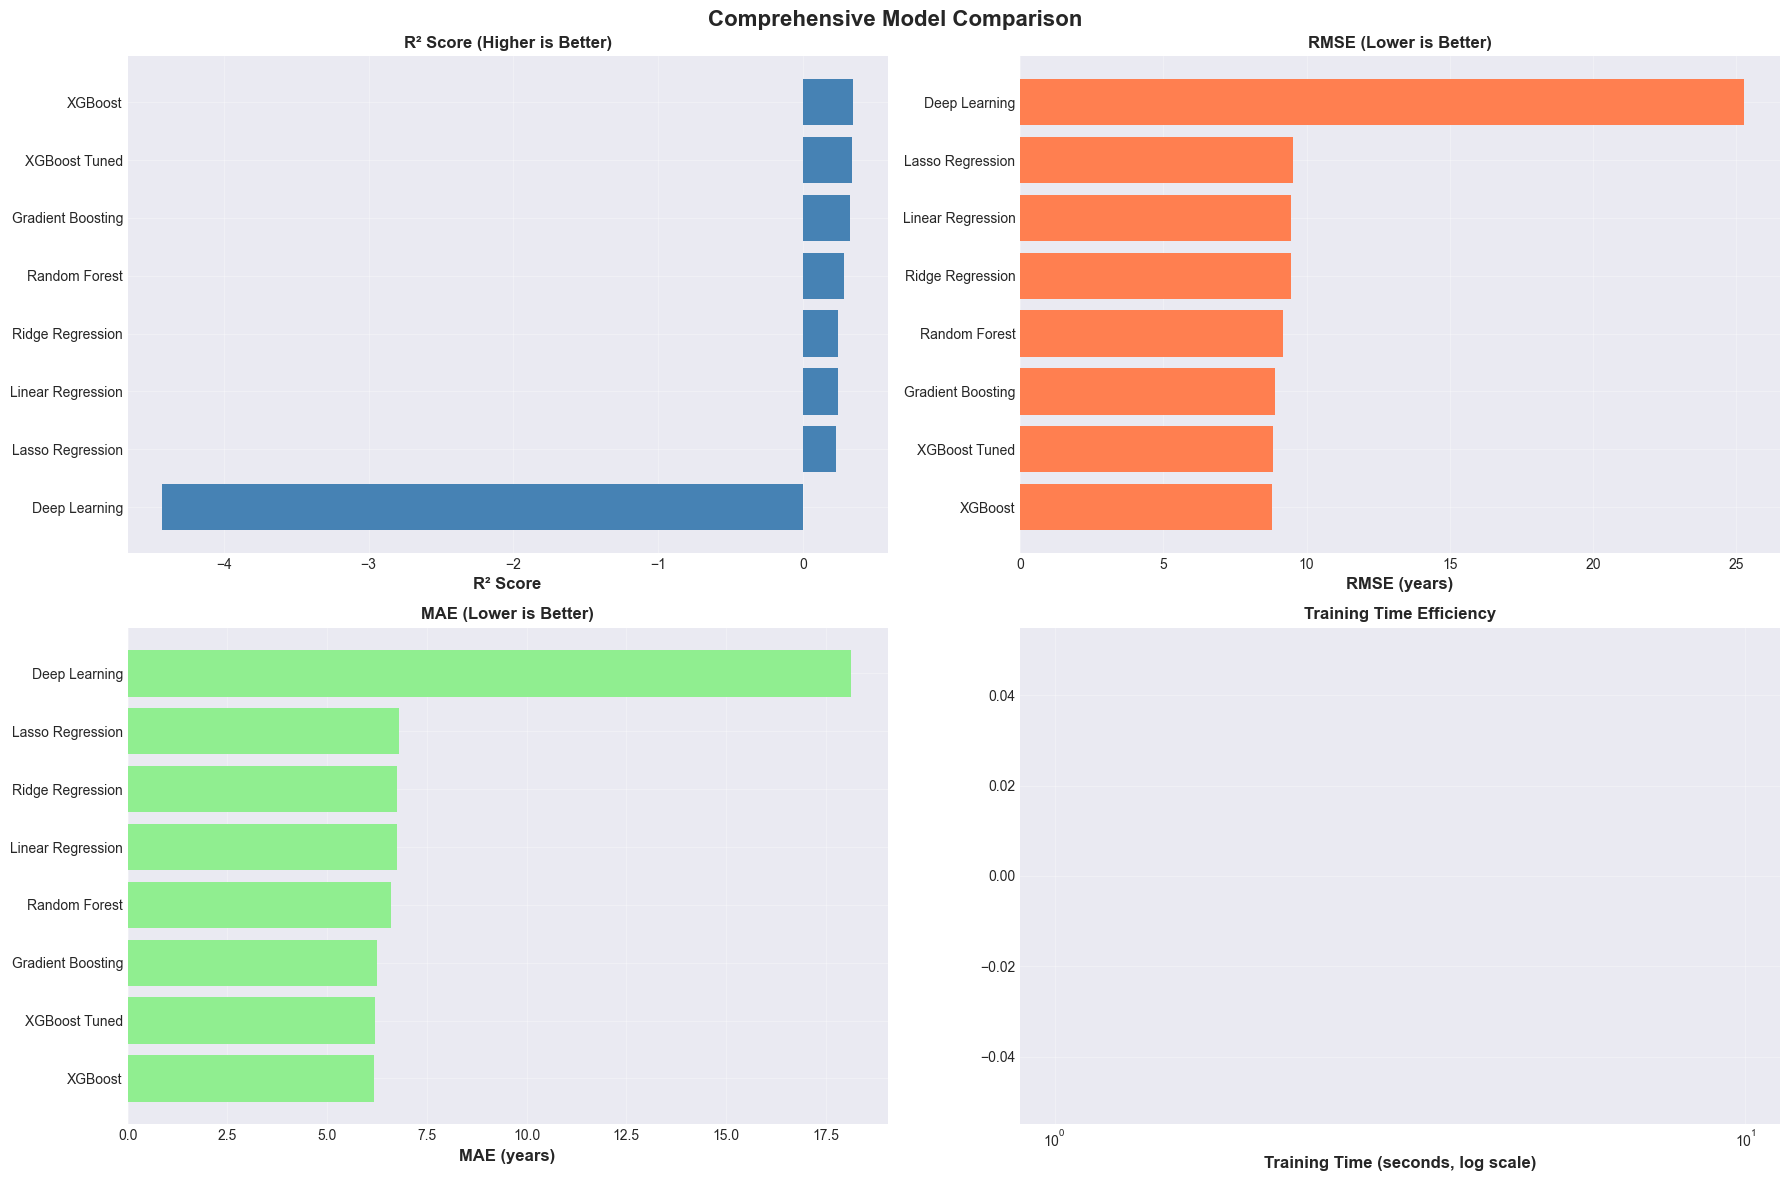


✅ Cross-Validation & Model Comparison Completed!


In [18]:
print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

# ============== CROSS-VALIDATION ON BEST MODELS ==============
print("\n🔄 Running 5-Fold Cross-Validation on Top Models...")

models_cv = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Ridge Regression': Ridge(alpha=10.0, random_state=RANDOM_STATE),
    'XGBoost (Original)': xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        tree_method='hist'
    ),
    'XGBoost (Tuned)': xgb_tuned
}

cv_results = []

for model_name, model in models_cv.items():
    print(f"\n⏳ {model_name}...")

    # 5-fold CV with negative MSE scoring
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    rmse_scores = np.sqrt(-scores)

    cv_results.append({
        'Model': model_name,
        'CV_RMSE_Mean': rmse_scores.mean(),
        'CV_RMSE_Std': rmse_scores.std(),
        'CV_RMSE_Min': rmse_scores.min(),
        'CV_RMSE_Max': rmse_scores.max()
    })

    print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

cv_results_df = pd.DataFrame(cv_results)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*80)
print(cv_results_df.to_string(index=False))

# ============== COMPREHENSIVE MODEL COMPARISON ==============
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON (ALL MODELS)")
print("="*80)

# Consolidate all results
all_results_df = pd.DataFrame(results)

# Separate train and test results
train_results = all_results_df[all_results_df['Model'].str.contains('Train')].copy()
test_results = all_results_df[all_results_df['Model'].str.contains('Test')].copy()

# Clean model names
train_results['Model'] = train_results['Model'].str.replace(' (Train)', '')
test_results['Model'] = test_results['Model'].str.replace(' (Test)', '')

# Save comprehensive results
test_results.to_csv(f'{SAVE_DIR}comprehensive_results.csv', index=False)

print("\n📊 TEST SET RESULTS (Sorted by R²):")
print(test_results.sort_values('R2', ascending=False)[['Model', 'RMSE', 'MAE', 'R2', 'MAPE']].to_string(index=False))

# ============== VISUALIZATION: MODEL COMPARISON ==============
print("\n📊 Creating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Comprehensive Model Comparison', fontsize=16, fontweight='bold')

# Sort by R2 score
test_results_sorted = test_results.sort_values('R2', ascending=True)

# 1. R² Score
axes[0, 0].barh(test_results_sorted['Model'], test_results_sorted['R2'], color='steelblue')
axes[0, 0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. RMSE
test_results_rmse = test_results.sort_values('RMSE', ascending=True)
axes[0, 1].barh(test_results_rmse['Model'], test_results_rmse['RMSE'], color='coral')
axes[0, 1].set_xlabel('RMSE (years)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. MAE
test_results_mae = test_results.sort_values('MAE', ascending=True)
axes[1, 0].barh(test_results_mae['Model'], test_results_mae['MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE (years)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('MAE (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Training Time (log scale)
test_with_time = test_results[test_results['Train_Time'].notna()].sort_values('Train_Time', ascending=True)
axes[1, 1].barh(test_with_time['Model'], test_with_time['Train_Time'], color='gold')
axes[1, 1].set_xlabel('Training Time (seconds, log scale)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Training Time Efficiency', fontsize=12, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}07_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Cross-Validation & Model Comparison Completed!")

SECTION 11: FINAL EVALUATION & COMPREHENSIVE VISUALIZATION


FINAL EVALUATION - BEST MODEL

🏆 BEST MODEL: XGBoost
   R² Score: 0.3454
   RMSE: 8.7772 years
   MAE: 6.1673 years

📊 PREDICTION ANALYSIS
--------------------------------------------------------------------------------

Residual Statistics:
  Mean: 0.0826
  Std:  8.8223
  Min:  -68.1902
  Max:  34.5286

Prediction Accuracy:
  Within ±1 year : 12.63%
  Within ±3 years: 36.57%
  Within ±5 years: 56.07%

📊 Creating final comprehensive visualizations...


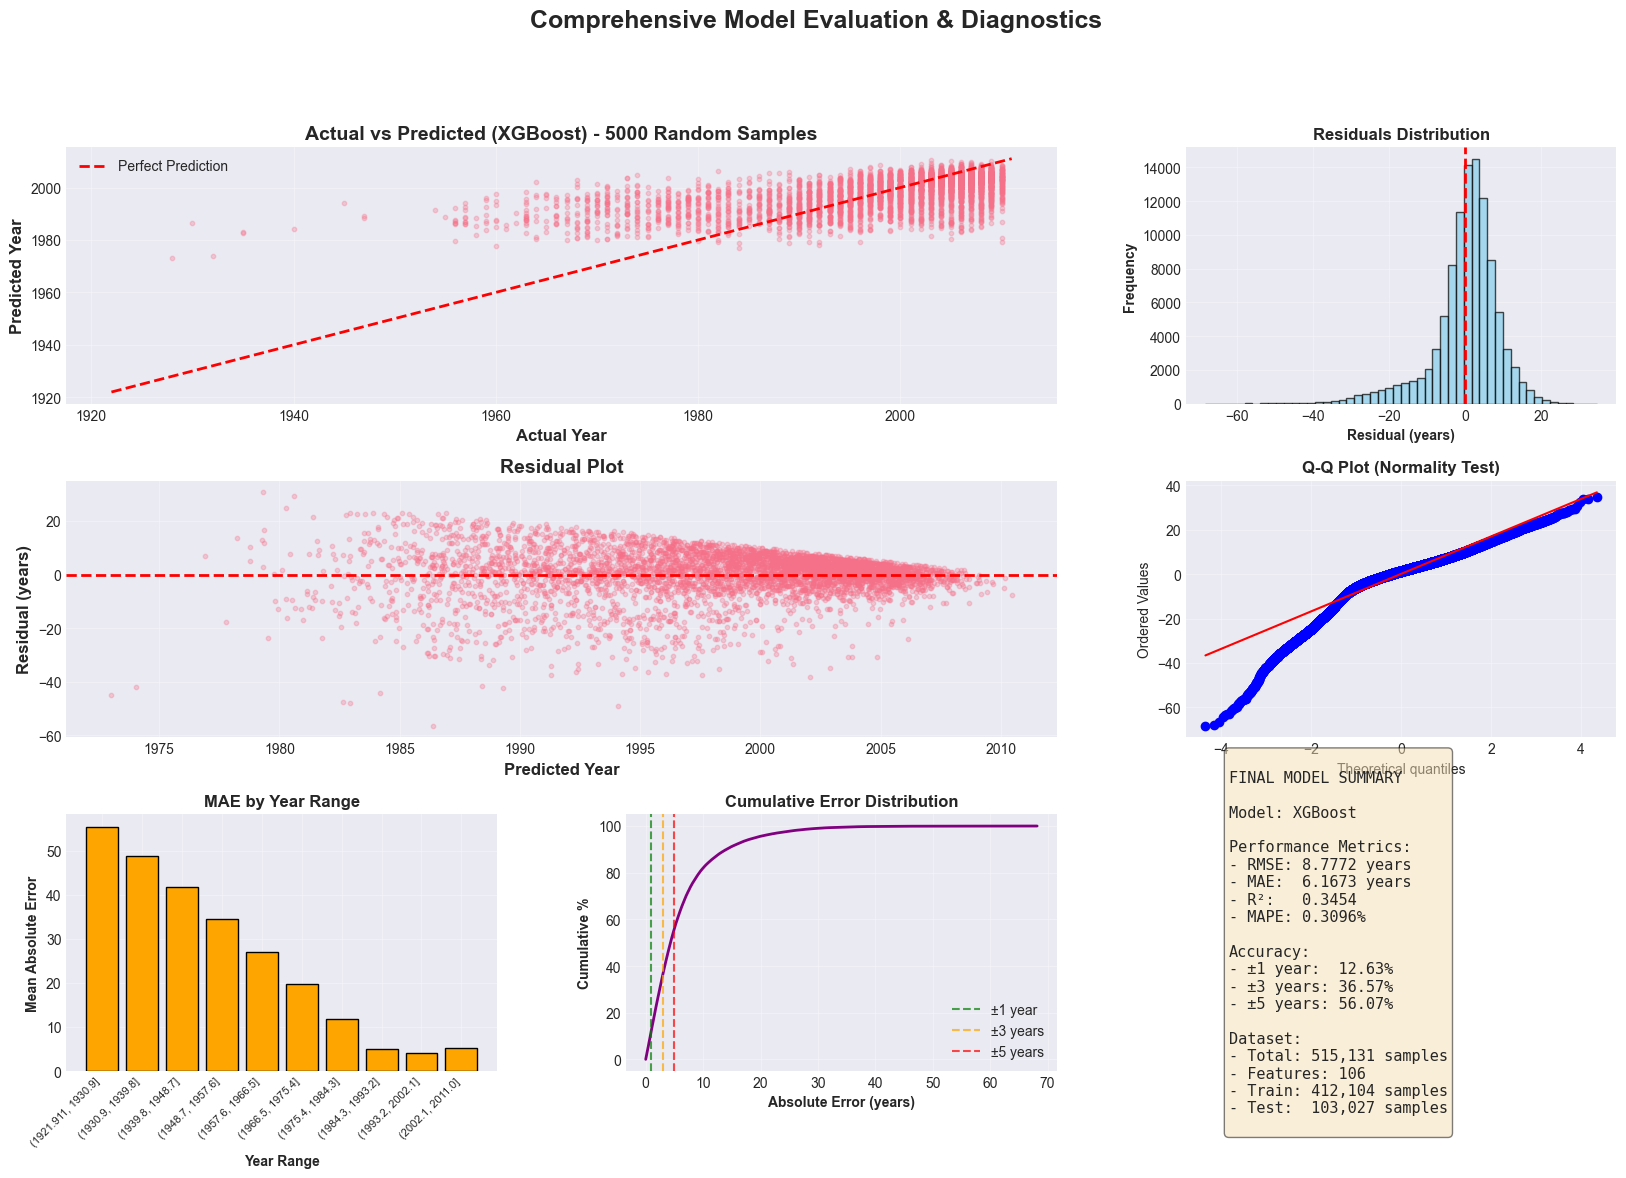


💾 Saving final summary report...

🎉 COMPLETE! ALL ANALYSES FINISHED!

✅ Best Model: XGBoost
✅ Final R² Score: 0.3454
✅ Final RMSE: 8.7772 years

📁 All results saved to: d:\Finalterm_ML\regresi



In [19]:
print("\n" + "="*80)
print("FINAL EVALUATION - BEST MODEL")
print("="*80)

# ============== IDENTIFY BEST MODEL ==============
best_model_row = test_results.sort_values('R2', ascending=False).iloc[0]
best_model_name = best_model_row['Model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_model_row['R2']:.4f}")
print(f"   RMSE: {best_model_row['RMSE']:.4f} years")
print(f"   MAE: {best_model_row['MAE']:.4f} years")

# Use tuned XGBoost as final model
final_model = xgb_tuned

# ============== PREDICTION ANALYSIS ==============
print("\n📊 PREDICTION ANALYSIS")
print("-"*80)

y_pred_final = final_model.predict(X_test)

# Residuals
residuals = y_test - y_pred_final

# Statistics
print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std:  {residuals.std():.4f}")
print(f"  Min:  {residuals.min():.4f}")
print(f"  Max:  {residuals.max():.4f}")

# Accuracy within tolerance
tolerance_1 = np.sum(np.abs(residuals) <= 1) / len(residuals) * 100
tolerance_3 = np.sum(np.abs(residuals) <= 3) / len(residuals) * 100
tolerance_5 = np.sum(np.abs(residuals) <= 5) / len(residuals) * 100

print(f"\nPrediction Accuracy:")
print(f"  Within ±1 year : {tolerance_1:.2f}%")
print(f"  Within ±3 years: {tolerance_3:.2f}%")
print(f"  Within ±5 years: {tolerance_5:.2f}%")

# ============== COMPREHENSIVE VISUALIZATION ==============
print("\n📊 Creating final comprehensive visualizations...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Actual vs Predicted (Scatter)
ax1 = fig.add_subplot(gs[0, :2])
sample_indices = np.random.choice(len(y_test), 5000, replace=False)
ax1.scatter(y_test.iloc[sample_indices], y_pred_final[sample_indices], alpha=0.3, s=10)
min_val, max_val = y_test.min(), y_test.max()
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Year', fontsize=12, fontweight='bold')
ax1.set_title(f'Actual vs Predicted ({best_model_name}) - 5000 Random Samples', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals Distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Residual (years)', fontsize=10, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=10, fontweight='bold')
ax2.set_title('Residuals Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Residuals vs Predicted
ax3 = fig.add_subplot(gs[1, :2])
ax3.scatter(y_pred_final[sample_indices], residuals.iloc[sample_indices], alpha=0.3, s=10)
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Year', fontsize=12, fontweight='bold')
ax3.set_ylabel('Residual (years)', fontsize=12, fontweight='bold')
ax3.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Q-Q Plot
ax4 = fig.add_subplot(gs[1, 2])
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Prediction Error by Year Range
ax5 = fig.add_subplot(gs[2, 0])
year_bins = pd.cut(y_test, bins=10)
error_by_year = pd.DataFrame({'Year_Bin': year_bins, 'Error': np.abs(residuals)})
error_summary = error_by_year.groupby('Year_Bin')['Error'].mean()
ax5.bar(range(len(error_summary)), error_summary.values, color='orange', edgecolor='black')
ax5.set_xlabel('Year Range', fontsize=10, fontweight='bold')
ax5.set_ylabel('Mean Absolute Error', fontsize=10, fontweight='bold')
ax5.set_title('MAE by Year Range', fontsize=12, fontweight='bold')
ax5.set_xticks(range(len(error_summary)))
ax5.set_xticklabels([str(x) for x in error_summary.index], rotation=45, ha='right', fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Cumulative Error Distribution
ax6 = fig.add_subplot(gs[2, 1])
abs_errors = np.abs(residuals).sort_values()
cumulative_pct = np.arange(1, len(abs_errors)+1) / len(abs_errors) * 100
ax6.plot(abs_errors.values, cumulative_pct, linewidth=2, color='purple')
ax6.axvline(1, color='green', linestyle='--', alpha=0.7, label='±1 year')
ax6.axvline(3, color='orange', linestyle='--', alpha=0.7, label='±3 years')
ax6.axvline(5, color='red', linestyle='--', alpha=0.7, label='±5 years')
ax6.set_xlabel('Absolute Error (years)', fontsize=10, fontweight='bold')
ax6.set_ylabel('Cumulative %', fontsize=10, fontweight='bold')
ax6.set_title('Cumulative Error Distribution', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Model Performance Summary (Text)
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
summary_text = f"""
FINAL MODEL SUMMARY

Model: {best_model_name}

Performance Metrics:
- RMSE: {best_model_row['RMSE']:.4f} years
- MAE:  {best_model_row['MAE']:.4f} years
- R²:   {best_model_row['R2']:.4f}
- MAPE: {best_model_row['MAPE']:.4f}%

Accuracy:
- ±1 year:  {tolerance_1:.2f}%
- ±3 years: {tolerance_3:.2f}%
- ±5 years: {tolerance_5:.2f}%

Dataset:
- Total: {len(df_final):,} samples
- Features: {X_train.shape[1]}
- Train: {len(X_train):,} samples
- Test:  {len(X_test):,} samples
"""
ax7.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

fig.suptitle('Comprehensive Model Evaluation & Diagnostics', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(f'{SAVE_DIR}08_final_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# ============== SAVE FINAL SUMMARY ==============
print("\n💾 Saving final summary report...")

summary_report = {
    'Best_Model': best_model_name,
    'Test_RMSE': best_model_row['RMSE'],
    'Test_MAE': best_model_row['MAE'],
    'Test_R2': best_model_row['R2'],
    'Test_MAPE': best_model_row['MAPE'],
    'Accuracy_1year': tolerance_1,
    'Accuracy_3years': tolerance_3,
    'Accuracy_5years': tolerance_5,
    'Total_Features': X_train.shape[1],
    'Training_Samples': len(X_train),
    'Test_Samples': len(X_test)
}

pd.DataFrame([summary_report]).to_csv(f'{SAVE_DIR}final_summary.csv', index=False)

print("\n" + "="*80)
print("🎉 COMPLETE! ALL ANALYSES FINISHED!")
print("="*80)
print(f"\n✅ Best Model: {best_model_name}")
print(f"✅ Final R² Score: {best_model_row['R2']:.4f}")
print(f"✅ Final RMSE: {best_model_row['RMSE']:.4f} years")
print(f"\n📁 All results saved to: {SAVE_DIR}")
print("\n" + "="*80)